<a href="https://colab.research.google.com/github/alerodriguessf/predicting-apple-stock-price/blob/main/Portfolio_Predicting_Apple_Stock_Price_SARIMAX_20250114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Apple Stock Price using SARIMAX

### Step 1: Importing Necessary Libraries
### The following libraries are required for data manipulation, visualization, and modeling.

In [1]:
!pip install scipy
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00


In [2]:
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse


### Step 2: Data Acquisition

In [3]:
# Uploading the dataset through the Google Colab file upload functionality.

from google.colab import files

uploaded = files.upload()


Saving price_apple.xlsx to price_apple.xlsx


### Step 3: Loading the Dataset


In [4]:
# We load the dataset into a Pandas DataFrame for analysis. This dataset contains stock prices for Apple.

df = pd.read_excel('price_apple.xlsx')

In [5]:
# Displaying the first 10 rows of the dataset to understand its structure.
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400
3,2008-10-06,3.284286,3.527857,3.126429,3.505000,2.992681,2107417200
4,2008-10-07,3.588571,3.625000,3.176786,3.184286,2.718845,1878772000
5,2008-10-08,3.068214,3.440357,3.060000,3.206786,2.738056,2207741200
6,2008-10-09,3.333929,3.421429,3.092857,3.169286,2.706038,1617383600
7,2008-10-10,3.060714,3.571429,3.035714,3.457143,2.951819,2219299600
8,2008-10-13,3.733929,3.947500,3.607857,3.937857,3.362268,1539076000
9,2008-10-14,4.152143,4.157143,3.683571,3.717143,3.173815,1980994400


### Step 4: Feature Engineering


In [6]:
# We create a new feature 'mean' that calculates the average of the 'Low' and 'High' prices for each day.

df['mean'] = (df['Low'] + df['High'])/2

In [7]:
# Displaying the updated DataFrame with the new 'mean' column.

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mean
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964
3,2008-10-06,3.284286,3.527857,3.126429,3.505000,2.992681,2107417200,3.327143
4,2008-10-07,3.588571,3.625000,3.176786,3.184286,2.718845,1878772000,3.400893


### Step 5: Shifting the Target Variable for Prediction


In [8]:
# We shift the 'mean' column by -1 to create a column 'Actual' representing the target variable for prediction.
# We do this to model the future price (next day's average price).

steps = -1
df_pred = df.copy()
df_pred['Actual'] = df_pred['mean'].shift(steps)
df_pred.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mean,Actual
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107,3.728393
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393,3.591964
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964,3.327143
3,2008-10-06,3.284286,3.527857,3.126429,3.505000,2.992681,2107417200,3.327143,3.400893
4,2008-10-07,3.588571,3.625000,3.176786,3.184286,2.718845,1878772000,3.400893,3.250179


### Step 6: Cleaning the Data


In [9]:
# Dropping any rows with missing values due to the shift operation, ensuring data consistency for model training.

df_pred = df_pred.dropna()

### Step 7: Converting Date Column to Datetime and Setting as Index


In [10]:
# Converting 'Date' to a datetime object and setting it as the index of the DataFrame for easier time-series manipulation.

df_pred['Date'] = pd.to_datetime(df_pred['Date'])
df_pred.index = df_pred['Date']

<ipython-input-10-ad353a1f0e00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['Date'] = pd.to_datetime(df_pred['Date'])


### Step 8: Visualizing the 'mean' Column


<Axes: xlabel='Date'>

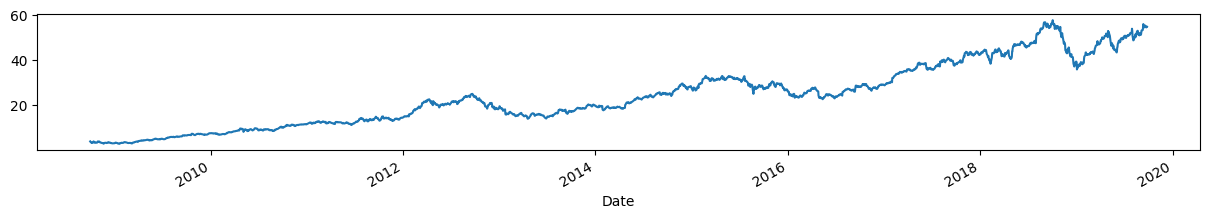

In [11]:
# Plotting the 'mean' column to get an initial understanding of the data's trend and seasonality.

df_pred[
    'mean'
    ].plot(figsize = (15, 2))

### Step 9: Seasonal Decomposition of the Time Series


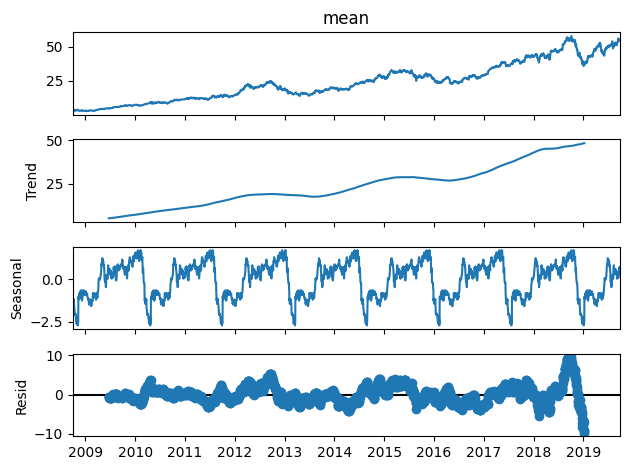

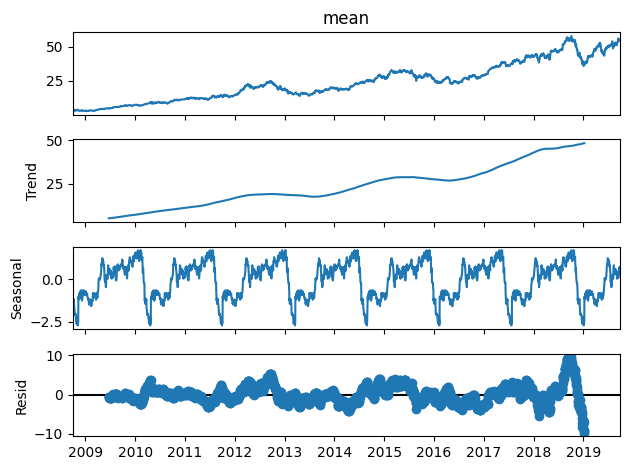

In [12]:
# Decomposing the 'mean' series using an additive model to understand its seasonal, trend, and residual components.

sd = sm.tsa.seasonal_decompose(df_pred['mean'], model = 'additive', period = 365)
sd.plot()

### Step 10: Feature Scaling


In [13]:
# We use MinMaxScaler to normalize the features to a range between 0 and 1 for both input features (X) and target variable (Y).

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_input = scaler.fit_transform(df_pred[['Low', 'High', 'Close', 'Adj Close', 'Volume','mean']])
scaler_input = pd.DataFrame(scaler_input)
x = scaler_input # Assigning the scaled values to the input features (X)


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_output = scaler.fit_transform(df_pred[['Actual']]) # Scaling the target variable (Actual)
scaler_ouput = pd.DataFrame(scaler_output)
y = scaler_output # Assigning the scaled values to the target variable (Y)

In [15]:
# Renaming columns for clarity
x.rename(columns = {0: 'Low', 1: 'High', 2: 'Close', 3: 'Adj Close', 4: 'Volume', 5: 'mean'}, inplace = True)
x.index = df_pred.index
x.head()

,Low,High,Close,Adj Close,Volume,mean
Date,,,,,,
2008-10-01,0.019075,0.019558,0.019996,0.017620,0.556275,0.019318
2008-10-02,0.014246,0.017258,0.014163,0.012480,0.695398,0.015763
2008-10-03,0.010750,0.015783,0.012203,0.010753,1.000000,0.013284
2008-10-06,0.006104,0.010810,0.012895,0.011363,0.916858,0.008474
2008-10-07,0.007025,0.012562,0.007088,0.006246,0.815191,0.009813


In [16]:
y = pd.DataFrame(scaler_output)
y.rename(columns = {0:'stock_price'}, inplace = True) # Renaming the target variable 'Preço_açao' (Stock Price)
y.index = df_pred.index
y.head()

,stock_price
Date,
2008-10-01,0.015763
2008-10-02,0.013284
2008-10-03,0.008474
2008-10-06,0.009813
2008-10-07,0.007075


### Step 11: Splitting the Data into Training and Test Sets


In [17]:
# We split the data into training and test sets (70% for training, 30% for testing) to evaluate the model's performance.

train_size = int(len(x) * 0.70)
test_size = int(len(df_pred)) - train_size
train_size, test_size

(1936, 830)

In [18]:
# Creating the training and testing sets for both input features (X) and target variable (Y)

train_x, train_y = x[:train_size], y[:train_size]
test_x, test_y = x[train_size:].dropna(), y[train_size:]

### Step 12: Automatic ARIMA Model Selection


In [19]:
# We use the auto_arima function from pmdarima to find the best parameters for the ARIMA model.

step_wise = auto_arima(train_y, exogenous = train_x,
                       trace = True,
                       start_p=1,
                       start_q=1,
                       max_p=7,
                       max_q=7,
                       d=1,
                       max_d= 7,
                       stepwise= True
                                              )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15130.709, Time=0.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15077.042, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15127.374, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15132.095, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15075.928, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15130.986, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15130.275, Time=2.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-15131.797, Time=0.55 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 6.113 seconds


In [20]:
# Displaying the summary of the best model found by auto_arima

step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1936
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7569.047
Date:                Tue, 21 Jan 2025   AIC                         -15132.095
Time:                        19:57:31   BIC                         -15115.391
Sample:                             0   HQIC                        -15125.952
                               - 1936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.414      0.157    -7.4e-05       0.000
ma.L1          0.1723      0.013     13.155      0.000       0.147       0.198
sigma2      2.339e-05   3.08e-07     75.974      0.000    2.28e-05     2.4e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9198.02
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.10   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


**Log-Likelihood**: 7569.047 indicates a good model fit.
AIC: -15132.095, BIC: -15115.391, and HQIC: -15125.952 all suggest the model is appropriate, with low values favoring good fit and penalizing overfitting.

**Coefficient Estimates:**

Intercept: 0.0002, though not statistically significant (p-value 0.157).
MA Term (ma.L1): 0.1723, highly significant (p-value < 0.0001), indicating that past errors significantly influence future stock prices.
Variance of Residuals (sigma2): 2.339e-05, with a z-score of 75.974, suggesting a good model fit with small residual variance.

**Model Diagnostics:**

Ljung-Box Test: p-value 0.97 shows no significant autocorrelation, indicating white noise residuals.
Jarque-Bera Test: p-value 0.00, rejecting normality and suggesting non-normal residuals.
Heteroskedasticity: p-value 0.00 indicates variance instability, implying heteroskedasticity in the model.
Skew: -0.37 suggests slight left-skewness in residuals.
Kurtosis: 13.66 indicates heavy-tailed residuals.

**Conclusion:** The SARIMAX model shows strong performance, with significant model parameters and good fit. However, residuals display non-normality and heteroskedasticity, which may require further adjustments to improve predictive accuracy and model robustness.

In [21]:
# Converting input features (X) and target variable (Y) to numpy arrays for SARIMAX compatibility

train_x = np.array(train_x)
train_y = np.array(train_y)

In [22]:
# Building the SARIMAX model with the best found parameters

model = SARIMAX(
    train_y,
    exog = train_x,
    order = (0, 1, 1),
    enforce_invertibility= False,
    enforce_stationarity= False
)

In [23]:
# Fitting the SARIMAX model to the training data
results = model.fit()

### Step 13: Making Predictions


In [24]:
## We predict future values using the fitted model on the test set.

pred = results.predict(start=train_size, end=train_size + test_size + (steps), exog=test_x)

### Step 14: Comparing Predictions with Actual Values


In [25]:
# We create a DataFrame for the actual stock prices and predictions to compare and evaluate the model.

act = pd.DataFrame(scaler_output[train_size:, 0])
act.index = test_x.index
act.rename(columns={0: 'Preço_açao'}, inplace=True)



In [26]:
# Organizing predictions for easy comparison

pred =pd.DataFrame(pred)
pred.reset_index(drop=True, inplace=True)
pred.index=test_x.index
pred['Actual'] = act['Preço_açao']
pred.rename(columns={0:'Predicted'}, inplace=True)
pred.head()

,Predicted,Actual
Date,,
2016-06-10,0.396885,0.393616
2016-06-13,0.390074,0.391368
2016-06-14,0.390671,0.391844
2016-06-15,0.389266,0.388166
2016-06-16,0.391131,0.383919


### Step 17: Visualizing Actual vs. Predicted Values


<Axes: xlabel='Date'>

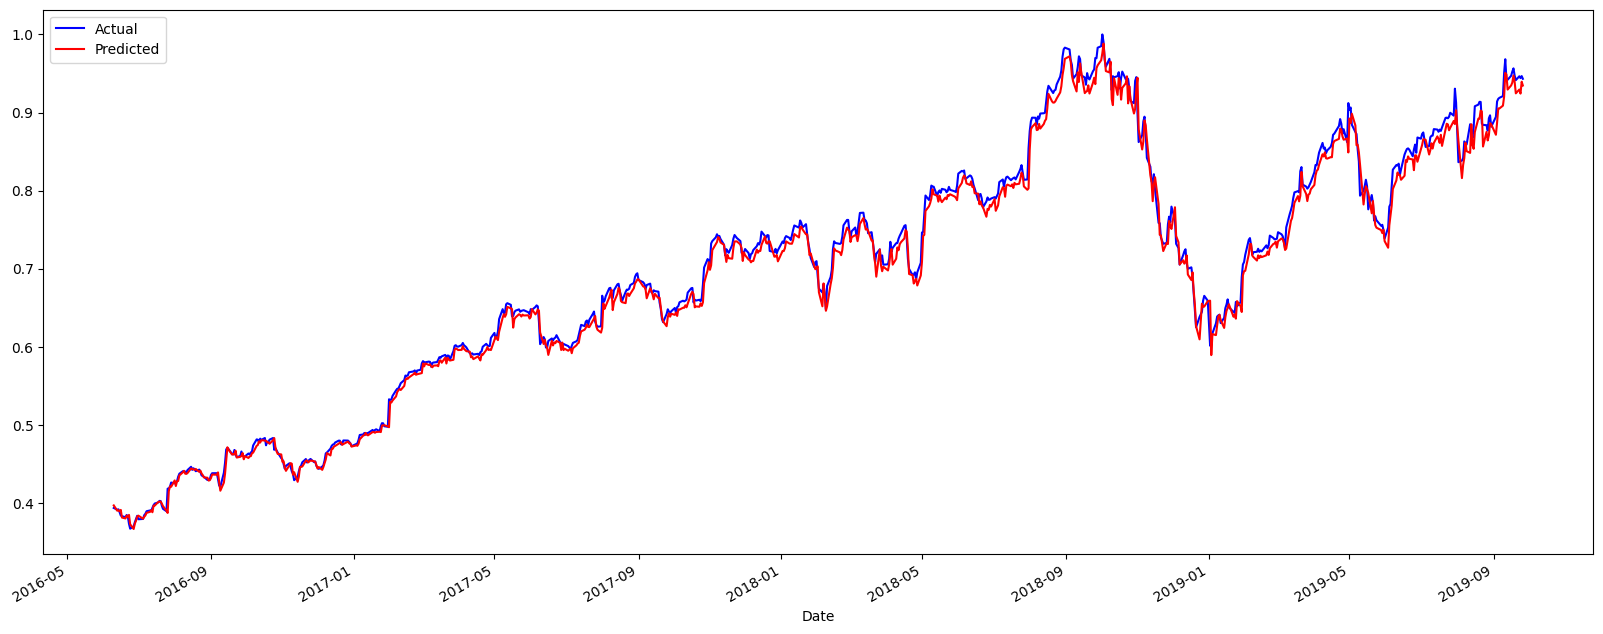

In [27]:
# We plot both the actual and predicted stock prices for visual comparison.

pred['Actual'].plot(figsize=(20,8), legend = True, color = 'blue')
pred['Predicted'].plot(legend= True, color='red', figsize=(20,8))

### Step 18: Model Evaluation


In [28]:
# Displaying the MSE to assess the model's performance

error = mse(pred['Actual'], pred['Predicted'])
error

0.000150831116141754

MSE value of 0.000150831116141754 reflects that the SARIMAX model has a relatively small prediction error.

In [29]:
# Displaying the MRSE to assess the model's performance

mrse = np.sqrt(error)
mrse

0.012281332018219928

 MRSE of 0.01228 confirms that the SARIMAX model has relatively small prediction errors.